# Water Pumps: EDA
**Plan:**
1. Relationships between date recorded and geographical location.
2. Relations between groups of categorical data.
3. Distributions of numerical data.

In [1]:
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
pd.__version__

'1.1.3'

In [3]:
sns.__version__

'0.11.0'

## Load Cleaned Data

In [4]:
df = pd.read_csv('../data/clean/cleaned_data.csv', index_col='id')

In [5]:
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
0,non functional,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
1,functional,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,none,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,functional,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,...,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
3,functional,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
4,non functional,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 74247
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59364 non-null  object 
 1   amount_tsh             59364 non-null  float64
 2   date_recorded          59364 non-null  object 
 3   funder                 59364 non-null  object 
 4   gps_height             59364 non-null  int64  
 5   installer              59364 non-null  object 
 6   longitude              59364 non-null  float64
 7   latitude               59364 non-null  float64
 8   wpt_name               59364 non-null  object 
 9   num_private            59364 non-null  int64  
 10  basin                  59364 non-null  object 
 11  subvillage             59364 non-null  object 
 12  region                 59364 non-null  object 
 13  region_code            59364 non-null  int64  
 14  district_code          59364 non-null  int64  
 15  lg

## EDA

### Dates and Geographical location
As indicated during data wrangling, it appears that the geographical locations were recorded twice. I will investigate on whether there is a relationship between when the record was made and the location.

In [7]:
geo_columns = ['longitude', 'latitude']
for column in geo_columns:
    print(df[column].value_counts().to_frame()[column].value_counts())

1       57443
2          72
1777        1
Name: longitude, dtype: int64
1       57445
2          71
1777        1
Name: latitude, dtype: int64


**Observations:**
* The majority of the geographical locations are unique.
* 71 geographical locations are recorded twice.
    * Could these pumps have been recorded on different days?
* One geographical location was recorded 1777 times.
    * This seems suspicious and is worth investigating.

In [8]:
geo_columns = ['longitude', 'latitude']
for column in geo_columns:
    print(df[column].value_counts().to_frame())

           longitude
0.000000        1777
33.010510          2
39.095087          2
39.099069          2
39.085965          2
...              ...
31.789709          1
37.095085          1
39.183964          1
34.341160          1
35.256844          1

[57516 rows x 1 columns]
               latitude
-2.000000e-08      1777
-2.465246e+00         2
-6.957328e+00         2
-6.991294e+00         2
-2.490324e+00         2
...                 ...
-3.263586e+00         1
-9.564592e+00         1
-8.519241e+00         1
-9.342734e+00         1
-2.598965e+00         1

[57517 rows x 1 columns]


**Question:** Do these geographical coordinates even fall within the borders of Tanzania?

A Google map inspection reveals that these coordinates fall within the Atlantic Ocean! Therefore, they must have been used to indicate pumps with missing geographical information.

In [9]:
1777 / len(df)

0.0299339667138333

Less than three percent of the pumps are missing geographical locations. This is small, but not insignificant.

### Data types
Inspecting the dataset above reveals that the categorical variable data types were lost when converting the file to a csv file. I will re-add them here.

In [10]:
categorical_vars = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code',
                   'lga', 'ward', 'public_meeting', 'permit', 'construction_year',
                   'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group',
                   'payment_type', 'water_quality', 'quality_group', 'quantity_group', 'source', 'source_type', 
                    'source_class', 'waterpoint_type', 'waterpoint_type_group', 'scheme_management', 'status_group', 
                   'payment', 'quantity']

In [11]:
categorical_dict = {x: 'category' for x in categorical_vars}

In [12]:
df = df.astype(categorical_dict)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 0 to 74247
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   status_group           59364 non-null  category
 1   amount_tsh             59364 non-null  float64 
 2   date_recorded          59364 non-null  object  
 3   funder                 59364 non-null  category
 4   gps_height             59364 non-null  int64   
 5   installer              59364 non-null  category
 6   longitude              59364 non-null  float64 
 7   latitude               59364 non-null  float64 
 8   wpt_name               59364 non-null  category
 9   num_private            59364 non-null  int64   
 10  basin                  59364 non-null  category
 11  subvillage             59364 non-null  category
 12  region                 59364 non-null  category
 13  region_code            59364 non-null  category
 14  district_code          59364 non-null 

## Distributions of numerical variables
**Plan:**
1. Create list of numerical column names.
2. Plot ECDF plots to visualize distributions. Use subplots.

In [14]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

In [15]:
print(numerical_columns)

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'population'],
      dtype='object')


In [16]:
num_cols_list = numerical_columns.to_list()
print(num_cols_list)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population']


In [17]:
sns.__version__

'0.11.0'

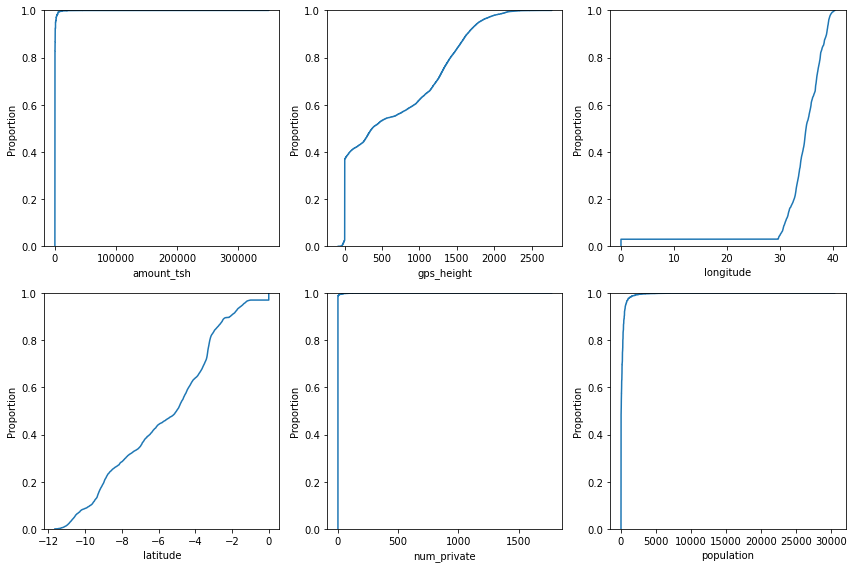

In [24]:
num_cols = 3
num_rows = 2

num_plots = len(num_cols_list)
num_cols = 3
num_rows = num_plots//num_cols

fix, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8))
for i, column in enumerate(num_cols_list):
    row_i = i // num_cols
    col_i = i % num_cols
    sns.ecdfplot(x=column, data=df, ax=ax[row_i, col_i])
plt.tight_layout()
plt.show()

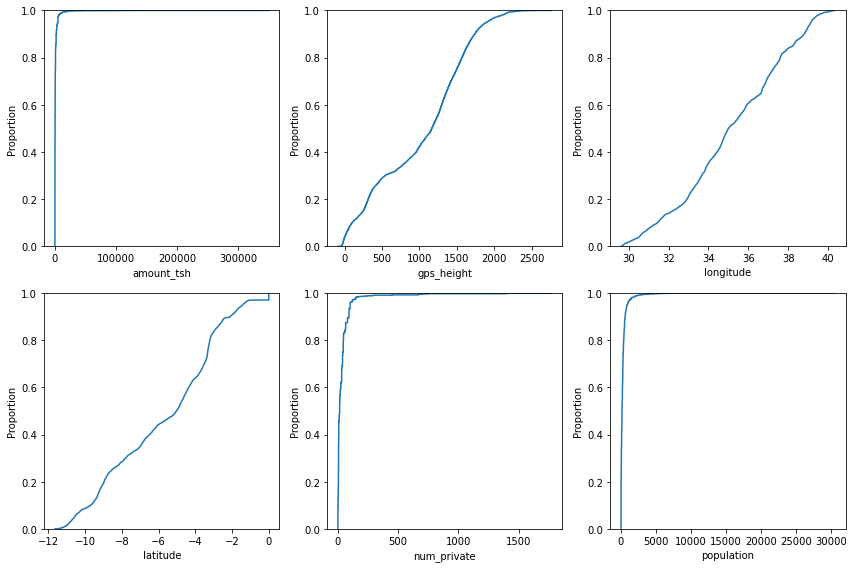

In [25]:
num_cols = 3
num_rows = 2

num_plots = len(num_cols_list)
num_cols = 3
num_rows = num_plots//num_cols

fix, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8))
for i, column in enumerate(num_cols_list):
    non_zero = df[column] != 0.0
    row_i = i // num_cols
    col_i = i % num_cols
    sns.ecdfplot(x=column, data=df[non_zero], ax=ax[row_i, col_i])
plt.tight_layout()
plt.show()